In [ ]:
# Importing required packages

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import shutil
import random
tf.__version__

'2.3.0'

In [ ]:
# Fetching normal x-ray images from kaggle

if os.path.isdir('chest_xray') is False:
    ! pip install -q kaggle
    from google.colab import files
    files.upload()
    ! mkdir ~/.kaggle 
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle datasets list
    ! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
    !unzip chest-xray-pneumonia.zip
    shutil.rmtree('/content/chest_xray/chest_xray')
    shutil.rmtree('/content/chest_xray/__MACOSX')
    os.remove('chest-xray-pneumonia.zip')

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [ ]:
def move_files(source, dest, num_of_samples):
  if num_of_samples=='all':
    filenames = os.listdir(source)
  else:
    filenames = random.sample(os.listdir(source), num_of_samples)
  for fname in filenames:
      srcpath = os.path.join(source, fname)
      shutil.move(srcpath, dest)
  os.chdir('/content')

In [ ]:
# Moving files from kaggle directory to our own directory

if os.path.isdir('/content/covid19_data') is False:
  os.mkdir('covid19_data')
  os.makedirs('/content/covid19_data/train/negative')
  os.makedirs('/content/covid19_data/train/positive')
  os.makedirs('/content/covid19_data/val/negative')
  os.makedirs('/content/covid19_data/val/positive')
  os.makedirs('/content/covid19_data/test/negative')
  os.makedirs('/content/covid19_data/test/positive')
  move_files('/content/chest_xray/train/NORMAL', '/content/covid19_data/train/negative', 800)
  move_files('/content/chest_xray/test/NORMAL', '/content/covid19_data/val/negative', 14)
  move_files('/content/chest_xray/test/NORMAL', '/content/covid19_data/test/negative', 186)
  shutil.rmtree('/content/chest_xray')

In [ ]:
# Fetching covid19 x-ray images from  github link

if os.path.isdir('/content/covid-chestxray-dataset') is False:
  ! git clone https://github.com/ieee8023/covid-chestxray-dataset.git
  positive_path = '/content/covid-chestxray-dataset/images'
  move_files(positive_path, '/content/covid19_data/train/positive', 730)
  move_files(positive_path, '/content/covid19_data/val/positive', 14)
  move_files(positive_path, '/content/covid19_data/test/positive', 186)
  shutil.rmtree('/content/covid-chestxray-dataset')

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3614 (delta 7), reused 11 (delta 5), pack-reused 3599
Receiving objects: 100% (3614/3614), 633.00 MiB | 42.81 MiB/s, done.
Resolving deltas: 100% (1431/1431), done.
Checking out files: 100% (1173/1173), done.


In [ ]:
# Path of the data

train_path = '/content/covid19_data/train'
valid_path = '/content/covid19_data/val'
test_path = '/content/covid19_data/test'

In [ ]:
# Data preprocessing

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['negative', 'positive'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['negative', 'positive'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=['negative', 'positive'], batch_size=10, shuffle=False)

Found 1530 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [ ]:
# CNN Model

model = Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Flatten(),
                    Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [ ]:
# Model training
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=1)

Epoch 1/15
153/153 [==============================] - 44s 286ms/step - loss: 27.1162 - accuracy: 0.9144 - val_loss: 0.2503 - val_accuracy: 0.8929
Epoch 2/15
153/153 [==============================] - 43s 283ms/step - loss: 0.0634 - accuracy: 0.9843 - val_loss: 0.4164 - val_accuracy: 0.9286
Epoch 3/15
153/153 [==============================] - 43s 283ms/step - loss: 0.1174 - accuracy: 0.9739 - val_loss: 0.8105 - val_accuracy: 0.9286
Epoch 4/15
153/153 [==============================] - 43s 283ms/step - loss: 0.0424 - accuracy: 0.9876 - val_loss: 3.4276 - val_accuracy: 0.7857
Epoch 5/15
153/153 [==============================] - 43s 281ms/step - loss: 0.1961 - accuracy: 0.9771 - val_loss: 1.3638 - val_accuracy: 0.8929
Epoch 6/15
153/153 [==============================] - 43s 279ms/step - loss: 0.0405 - accuracy: 0.9895 - val_loss: 1.4353 - val_accuracy: 0.9286
Epoch 7/15
153/153 [==============================] - 43s 279ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 1.6073 - val_a

In [ ]:
model.save('model_cnn.h5')

The accuracy of the model is: 0.9139784946236559
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       186
           1       0.86      0.99      0.92       186

    accuracy                           0.91       372
   macro avg       0.93      0.91      0.91       372
weighted avg       0.93      0.91      0.91       372



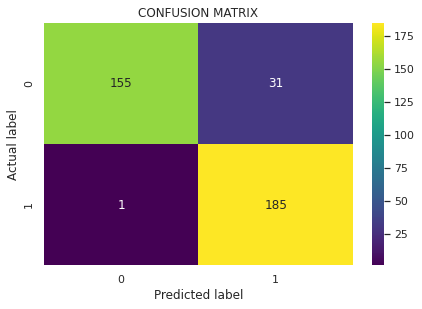

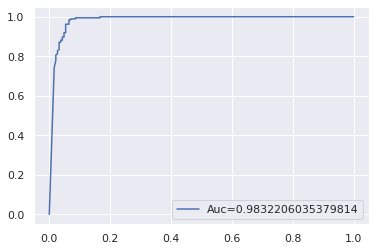

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score

sns.set()

def confusion_matrix_and_report(model, batch_to_pred):
  preds = model.predict(x=batch_to_pred)
  y_preds = np.argmax(preds, axis=-1)
  y_true = batch_to_pred.classes
  accuracy = accuracy_score(y_true, y_preds)
  print(f"The accuracy of the model is: {accuracy}")
  confuse = confusion_matrix(y_true, y_preds)
  report = classification_report(y_true, y_preds)
  print(report)    
  sns.heatmap(pd.DataFrame(confuse), annot=True, cmap='viridis', fmt='g')
  plt.tight_layout()
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
  plt.title('CONFUSION MATRIX')
  plt.show()

def roc_auc(model, batch_to_pred):
  proba_list = []
  preds = model.predict(x=batch_to_pred)[::,1]
  y_true = batch_to_pred.classes
  fpr, tpr, thresholds = roc_curve(y_true, preds)
  auc = roc_auc_score(y_true, preds)
  plt.plot(fpr,tpr,label="Auc="+str(auc))
  plt.legend(loc=4)

confusion_matrix_and_report(model, test_batches)
roc_auc(model, test_batches)

In [ ]:
# VGG16 model

vgg16_model = tf.keras.applications.vgg16.VGG16()

model_vgg16 = Sequential()
for layer in vgg16_model.layers[:-1]: #Except last layer
  model_vgg16.add(layer)

for layer in model_vgg16.layers: #Avoiding training layers
  layer.trainable=False

model_vgg16.add(Dense(units=2, activation='softmax')) #Adding custom last layer
#model.summary()

553467904/553467096 [==============================] - 4s 0us/step


Epoch 1/5
153/153 [==============================] - 46s 303ms/step - loss: 0.0680 - accuracy: 0.9745 - val_loss: 0.2125 - val_accuracy: 0.9286
Epoch 2/5
153/153 [==============================] - 46s 301ms/step - loss: 0.0204 - accuracy: 0.9915 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 3/5
153/153 [==============================] - 46s 302ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.1481 - val_accuracy: 0.9643
Epoch 4/5
153/153 [==============================] - 46s 300ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2019 - val_accuracy: 0.9286
Epoch 5/5
153/153 [==============================] - 46s 300ms/step - loss: 6.2088e-04 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9643
The accuracy of the model is: 0.9811827956989247
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       186
           1       0.96      1.00      0.98       186

    accuracy                           0.98       372
   macro 

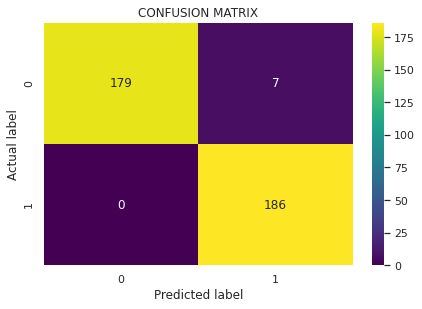

In [ ]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=1)

confusion_matrix_and_report(model_vgg16, test_batches)

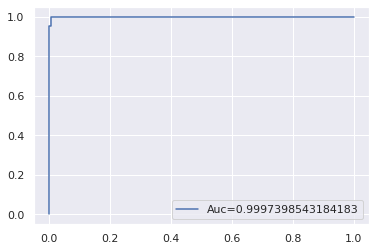

In [ ]:
roc_auc(model_vgg16, test_batches)

In [ ]:
model_vgg16.save('vgg16_model.h5')
print('SAVED')

SAVED


In [ ]:
# Mobile Net

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1530 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import Model

mobile = tf.keras.applications.mobilenet.MobileNet()
#mobile.summary()
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)
model_mobile = Model(inputs=mobile.input, outputs=output)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers[:-23]:
  layer.trainable=False
model_mobile.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_mobile.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=1)

Epoch 1/5
153/153 [==============================] - 49s 321ms/step - loss: 0.1558 - accuracy: 0.9569 - val_loss: 0.3843 - val_accuracy: 0.8929
Epoch 2/5
153/153 [==============================] - 49s 319ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.2303 - val_accuracy: 0.9286
Epoch 3/5
153/153 [==============================] - 49s 321ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0823 - val_accuracy: 0.9643
Epoch 4/5
153/153 [==============================] - 49s 319ms/step - loss: 0.0212 - accuracy: 0.9915 - val_loss: 0.3257 - val_accuracy: 0.9286
Epoch 5/5
153/153 [==============================] - 49s 319ms/step - loss: 0.0332 - accuracy: 0.9922 - val_loss: 0.0089 - val_accuracy: 1.0000


The accuracy of the model is: 0.9811827956989247
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       186
           1       0.99      0.97      0.98       186

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



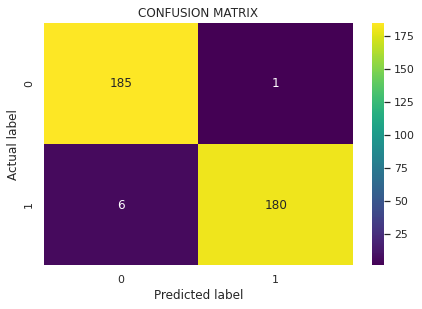

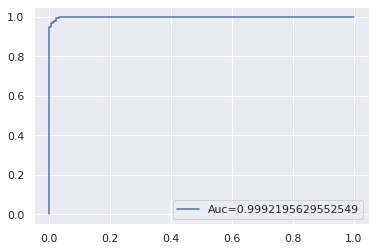

In [ ]:
confusion_matrix_and_report(model_mobile, test_batches)
roc_auc(model_mobile, test_batches)

In [ ]:
model_mobile.save('model_mobilenet.h5')
print("SAVED")

SAVED


COVID19 POSITIVE! TAKE CARE


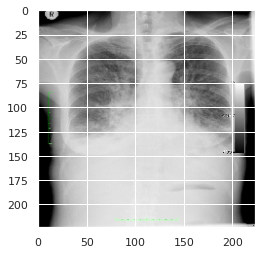

In [ ]:
# Predicting our own images

import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

model_dir = '/content/vgg16_model.h5'
image_dir = '/content/2.png'

model_loaded = load_model(model_dir)
img_width, img_height = 224, 224
img = image.load_img(image_dir, target_size = (img_width, img_height))
img = image.img_to_array(img)
plt.imshow(img/255.)
img = np.expand_dims(img, axis = 0)

result = np.argmax(model_loaded.predict(img), axis=-1)[0]
if(result==1):
  print("COVID19 POSITIVE! TAKE CARE")
else:
  print("COVID19 NEGATIVE! STAY SAFE")